# Linear Regression model to predict MVP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error, r2_score

### Load data, select appropriate variables, scale data

In [2]:
df = pd.read_csv("mvp_data.csv", index_col=0).reset_index(drop=True)
df = df.fillna(0)
df.columns

Index(['Year', 'Player', 'Tm', 'Share', 'G', 'MP', 'PTS', 'TRB', 'AST', 'STL',
       'BLK', 'FG%', '3P%', 'FT%', 'WS', 'WS/48', 'MVP',
       'player_efficiency_rating', 'true_shooting_percentage',
       'three_point_attempt_rate', 'free_throw_attempt_rate',
       'offensive_rebound_percentage', 'defensive_rebound_percentage',
       'total_rebound_percentage', 'assist_percentage', 'steal_percentage',
       'block_percentage', 'turnover_percentage', 'usage_percentage',
       'offensive_win_shares', 'defensive_win_shares',
       'offensive_box_plus_minus', 'defensive_box_plus_minus',
       'box_plus_minus', 'value_over_replacement_player', 'wl_pct', 'seed',
       'highest_teammate_vorp', 'highest_teammate_ws'],
      dtype='object')

In [3]:
# drop columns not used for regression prediction
drop_cols = ['Year', 'Player', 'Tm', 'Share', 'MVP']
X1 = df.drop(drop_cols, axis = 1)
y = df['Share']

# scale variables
scaler = StandardScaler()
X2 = scaler.fit_transform(X1)

### Use mutual info to analyze strength of predictors, select best ones

- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html

In [4]:
mutual_inf = mutual_info_regression(X2, y)
mutual_info = pd.Series(mutual_inf)
mutual_info.index = X1.columns
mutual_info.sort_values(ascending=False)

WS                               0.247174
WS/48                            0.237758
player_efficiency_rating         0.211231
value_over_replacement_player    0.192644
offensive_win_shares             0.171645
box_plus_minus                   0.154868
offensive_box_plus_minus         0.140745
free_throw_attempt_rate          0.120212
defensive_win_shares             0.110762
defensive_rebound_percentage     0.100006
wl_pct                           0.099604
seed                             0.099546
PTS                              0.090012
TRB                              0.074711
true_shooting_percentage         0.069310
assist_percentage                0.065113
usage_percentage                 0.044990
defensive_box_plus_minus         0.043753
steal_percentage                 0.035829
three_point_attempt_rate         0.018884
offensive_rebound_percentage     0.017178
highest_teammate_ws              0.014646
BLK                              0.007149
FG%                              0

<AxesSubplot:>

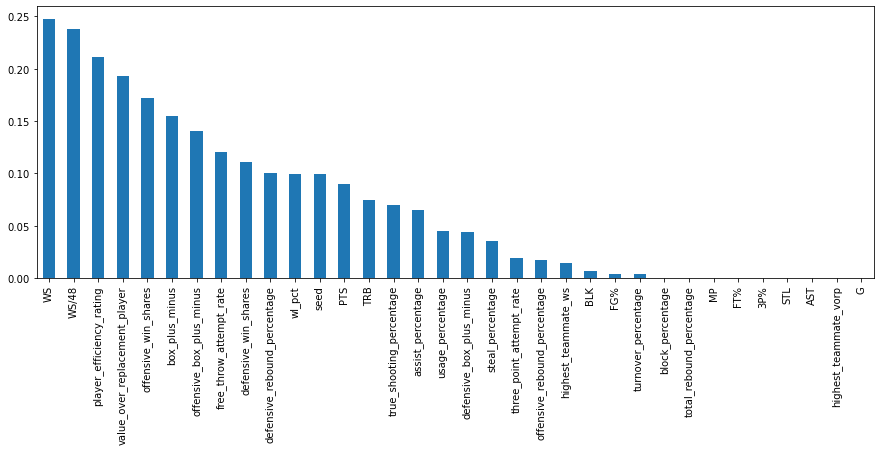

In [5]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

### try mutual info among players who got a share 0.35 and higher

In [6]:
# use only variables with above 0.11 mutual regression

cols = mutual_info[mutual_info > 0.09].index
repeats = ['WS', 'offensive_win_shares', 'defensive_win_shares', 'offensive_box_plus_minus']
cols = cols.drop(repeats)
cols

Index(['PTS', 'WS/48', 'player_efficiency_rating', 'free_throw_attempt_rate',
       'defensive_rebound_percentage', 'box_plus_minus',
       'value_over_replacement_player', 'wl_pct', 'seed'],
      dtype='object')

##### Repeat variables were ones that were combinations of each other. For example, box_plus_minus is a combination of offensive_box_plus_minus and defensive_box_plus_minus. Therefore we will only use the total statistic for these ones.

### Build Linear Regression model with entire data

In [7]:
X =  scaler.fit_transform(df[cols])
model = LinearRegression()
model.fit(X, y)

LinearRegression()

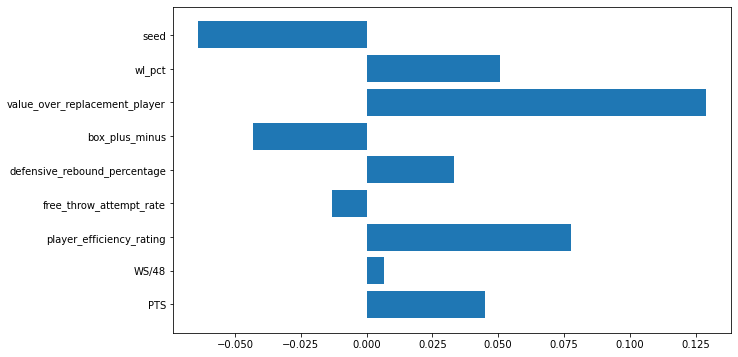

In [8]:
coefficients = model.coef_
plt.figure(figsize=(10,6))
plt.barh(cols, coefficients)
plt.show()

### Test coefficients without 1999, 2005, 2006

In [9]:
drop_yrs = [1999, 2005, 2006]
mask = ~df['Year'].isin(drop_yrs)
df1 = df[mask]

In [11]:
X =  scaler.fit_transform(df1[cols])
y = df1['Share']
model = LinearRegression()
model.fit(X, y)

LinearRegression()

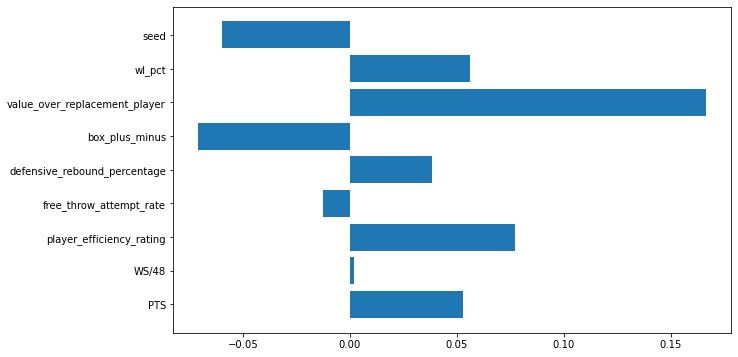

In [12]:
coefficients = model.coef_
plt.figure(figsize=(10,6))
plt.barh(cols, coefficients)
plt.show()

### Holdout single year as test set

In [13]:
df_train = df[df['Year'] != 2023]
df_test = df[df['Year'] == 2023]
X_train =  scaler.fit_transform(df_train[cols])
y_train = df_train['Share']
X_test =  scaler.fit_transform(df_test[cols])
y_test = df_test['Share']


In [14]:
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

### Evaluate with R2, MSE

In [15]:
r2_score(y_test, pred)

0.7682364269244601

In [16]:
mean_squared_error(y_test, pred)

0.024731361095289933

In [17]:
results = pd.DataFrame(y_test)
results['prediction'] = pred
results.index = df_test['Player']
results

,Share,prediction
Player,,
Joel Embiid,0.915,0.539173
Nikola Jokić,0.674,0.727295
Giannis Antetokounmpo,0.606,0.417272
Jayson Tatum,0.280,0.273998
Shai Gilgeous-Alexander,0.046,0.070559
Donovan Mitchell,0.030,0.092647
Domantas Sabonis,0.027,0.133788
Luka Dončić,0.010,0.222223
Stephen Curry,0.005,0.036586


In [16]:
results['pct_diff'] = results['prediction'] - results['Share']
results

,Share,prediction,pct_diff
Player,,,
Joel Embiid,0.915,0.402103,-0.512897
Nikola Jokić,0.674,0.468162,-0.205838
Giannis Antetokounmpo,0.606,0.306216,-0.299784
Jayson Tatum,0.280,0.227931,-0.052069
Shai Gilgeous-Alexander,0.046,0.142745,0.096745
Donovan Mitchell,0.030,0.121505,0.091505
Domantas Sabonis,0.027,0.079511,0.052511
Luka Dončić,0.010,0.202065,0.192065
Stephen Curry,0.005,0.027579,0.022579


### Create function to determine if MVP winner is correct

In [18]:
actual = results['Share'].idxmax()
prediction = results['prediction'].idxmax()

In [19]:
def mvp_prediction(actual, prediction):
    if actual == prediction:
        return 'Correct'
    else:
        return 'Wrong'

In [24]:
dat = pd.DataFrame()
dat['R2'] = [r2_score(y_test, pred)]
dat['MSE'] = [mean_squared_error(y_test, pred)]
dat['MVP'] = [mvp_prediction(actual, prediction)]
dat.index = [2021]
dat

,R2,MSE,MVP
2021,0.504162,0.046164,Correct


### Create function for all evaluations

In [20]:
def evaluate(y_test, preds):
    evals = []
    results = pd.DataFrame(y_test)
    results['prediction'] = preds
    results.index = df_test['Player']
    actual = results['Share'].idxmax()
    prediction = results['prediction'].idxmax()
    evals.append(r2_score(y_test, pred))
    evals.append(mean_squared_error(y_test, pred))
    evals.append(mvp_prediction(actual, prediction))
    return evals

### For loop to use each year as a test set

In [21]:
# empty dict to store results
evals_by_year = {}

for year in range(1980, 2024):
    df_train = df[df['Year'] != year]
    df_test = df[df['Year'] == year]
    X_train =  scaler.fit_transform(df_train[cols])
    y_train = df_train['Share']
    X_test =  scaler.fit_transform(df_test[cols])
    y_test = df_test['Share']
    model = LinearRegression()
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    eval = evaluate(y_test, pred)
    evals_by_year[year] = eval
    

In [22]:
lin_reg = pd.DataFrame(list(evals_by_year.values()), index=evals_by_year.keys())
lin_reg.columns = ['R2', 'MSE', 'MVP']
lin_reg.sort_values(by='MVP')

,R2,MSE,MVP
1980,-0.126939,0.045538,Correct
2010,0.768606,0.022196,Correct
2004,0.744567,0.023868,Correct
2003,0.455171,0.045528,Correct
2002,0.316246,0.057562,Correct
2000,0.864857,0.009442,Correct
2012,0.734823,0.024489,Correct
2013,0.772539,0.022172,Correct
2014,0.744644,0.026442,Correct
1996,0.772655,0.018661,Correct


In [23]:
lin_reg['MVP'].value_counts()

Correct    26
Wrong      18
Name: MVP, dtype: int64

In [24]:
lin_reg.mean(axis=0)

/var/folders/vv/5y3czrp10w7dkbkrzmk_d70m0000gn/T/ipykernel_79676/2357479025.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  lin_reg.mean(axis=0)


R2     0.572701
MSE    0.034898
dtype: float64

#### Test without years 2005, 2006, 1999

In [31]:
drop_yrs = [1999, 2005, 2006]
yrs = range(1980, 2024)
yrs = [y for y in yrs if y not in drop_yrs]
#yrs

In [32]:
# empty dict to store results
evals_by_year = {}

for year in yrs:
    df_train = df1[df1['Year'] != year]
    df_test = df1[df1['Year'] == year]
    X_train =  scaler.fit_transform(df_train[cols])
    y_train = df_train['Share']
    X_test =  scaler.fit_transform(df_test[cols])
    y_test = df_test['Share']
    model = LinearRegression()
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    eval = evaluate(y_test, pred)
    evals_by_year[year] = eval

In [33]:
lin_reg = pd.DataFrame(list(evals_by_year.values()), index=evals_by_year.keys())
lin_reg.columns = ['R2', 'MSE', 'MVP']
lin_reg.index.name='Idx'
lin_reg.sort_values(by = ['MVP', 'Idx'], ascending = [False, True])

,R2,MSE,MVP
Idx,,,
1982,0.152743,0.041273,Wrong
1983,0.416471,0.047402,Wrong
1987,0.604027,0.033353,Wrong
1989,0.780978,0.016239,Wrong
1990,0.643986,0.026011,Wrong
1993,0.664256,0.032225,Wrong
1994,0.625423,0.034465,Wrong
1997,0.846496,0.014495,Wrong
1998,0.683205,0.031948,Wrong


In [34]:
lin_reg['MVP'].value_counts()

Correct    27
Wrong      14
Name: MVP, dtype: int64

In [35]:
lin_reg.mean(axis=0)

/var/folders/vv/5y3czrp10w7dkbkrzmk_d70m0000gn/T/ipykernel_79676/2357479025.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  lin_reg.mean(axis=0)


R2     0.629962
MSE    0.030470
dtype: float64